In [1]:
%load_ext sql
import pandas as pd
import sqlite3 
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import prettytable

prettytable.DEFAULT = 'DEFAULT'

In [3]:
df = pd.read_excel("Online Retail.xlsx")

print(f"Database shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nfirst 5 rows:")
df.head(5)

Database shape: (541909, 8)
Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

first 5 rows:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [9]:
print(f"Total Null Values: {df.isna().sum()}")

Total Null Values: InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


## Data Cleaning

In [11]:
df_clean = df.copy()

In [13]:
df_clean = df.dropna(subset=['CustomerID'])

In [15]:
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] >0)]

In [17]:
df_clean['CustomerID'] = df_clean['CustomerID'].astype(int)

df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

df_clean['Year'] = df_clean['InvoiceDate'].dt.year
df_clean['Month'] = df_clean['InvoiceDate'].dt.month
df_clean['Day'] = df_clean['InvoiceDate'].dt.day

In [19]:
df_clean['TotalAmount'] = df_clean['Quantity'] * df_clean['UnitPrice']

print(f"\nfirst 5 rows:")
df_clean.head(5)


first 5 rows:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010,12,1,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010,12,1,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,20.34


## SQL

In [21]:
conn = sqlite3.connect('Retail.db')
cursor = conn.cursor()
print("Connnection to Retail.db established successfully.")

Connnection to Retail.db established successfully.


In [23]:
engine = create_engine("sqlite:///Retail.db")
df_clean.to_sql('transactions', engine, if_exists='replace', index=False)

print("Table created successfully")

Table created successfully


In [25]:
%sql sqlite:///Retail.db

## EDA

In [70]:
%%sql
SELECT COUNT(DISTINCT CustomerID) AS UniqueCustomers,
COUNT(DISTINCT StockCode) AS UniqueProducts,
COUNT(DISTINCT Country) AS UniqueCountires,
MIN(InvoiceDate) AS EarliestDate,
MAX(InvoiceDate) AS LatestDate
FROM Transactions;

 * sqlite:///Retail.db
Done.


UniqueCustomers,UniqueProducts,UniqueCountires,EarliestDate,LatestDate
4338,3665,37,2010-12-01 08:26:00.000000,2011-12-09 12:50:00.000000


### Revenue Analysis

In [64]:
%%sql 
SELECT ROUND(SUM(TotalAmount),2) AS TotalRevenue, 
ROUND(AVG(TotalAmount),2) AS AverageValue, 
ROUND(SUM(TotalAmount),2) / COUNT(DISTINCT CustomerID) AS RevenuePerCustomer, 
COUNT(*) AS TotalTransactions 
FROM Transactions;

 * sqlite:///Retail.db
Done.


TotalRevenue,AverageValue,RevenuePerCustomer,TotalTransactions
8911407.9,22.4,2054.2664591977873,397884


### Top Country Analysis

In [179]:
CountrySales = %sql SELECT Country, ROUND(SUM(TotalAmount),2) AS Total, ROUND(AVG(TotalAmount),2) AS AverageSales, COUNT(DISTINCT InvoiceNo) AS TotalTransactions, COUNT(DISTINCT CustomerID) AS UniqueCustomers FROM transactions GROUP BY Country ORDER BY Total DESC LIMIT 10;
CountrySales

 * sqlite:///Retail.db
Done.


Country,Total,AverageSales,TotalTransactions,UniqueCustomers
United Kingdom,7308391.55,20.63,16646,3920
Netherlands,285446.34,121.0,94,9
EIRE,265545.9,36.7,260,3
Germany,228867.14,25.32,457,94
France,209024.05,25.06,389,87
Australia,138521.31,117.19,57,9
Spain,61577.11,24.79,90,30
Switzerland,56443.95,30.66,51,21
Belgium,41196.34,20.28,98,25
Sweden,38378.33,85.1,36,8


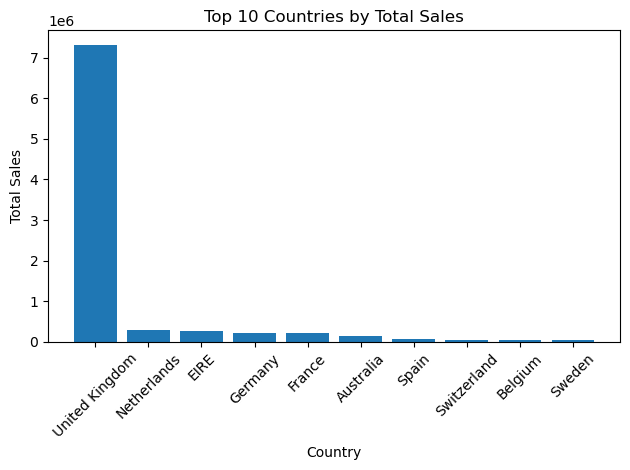

In [181]:
CountryDf = CountrySales.DataFrame()

plt.bar(CountryDf['Country'], CountryDf['Total'])
plt.xlabel('Country')
plt.ylabel('Total Sales')
plt.title('Top 10 Countries by Total Sales')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

### Monthly Sales Trend

In [148]:
MonthlySales = %sql SELECT Year, Month, CASE Month WHEN 1 THEN 'January' WHEN 2 THEN 'February' WHEN 3 THEN 'March' WHEN 4 THEN 'April' WHEN 5 THEN 'May' WHEN 6 THEN 'June' WHEN 7 THEN 'July' WHEN 8 THEN 'August' WHEN 9 THEN 'September' WHEN 10 THEN 'October' WHEN 11 THEN 'November'  WHEN 12 THEN 'DECEMBER' END AS MonthName, COUNT(*) AS TotalTransactions, ROUND(SUM(TotalAmount),2) AS MonthlySales, COUNT(DISTINCT CustomerID) AS ActiveCustomers FROM Transactions GROUP BY Year, Month ORDER BY Year, Month
MonthlySales

 * sqlite:///Retail.db
Done.


Year,Month,MonthName,TotalTransactions,MonthlySales,ActiveCustomers
2010,12,DECEMBER,26157,572713.89,885
2011,1,January,21229,569445.04,741
2011,2,February,19927,447137.35,758
2011,3,March,27175,595500.76,974
2011,4,April,22642,469200.36,856
2011,5,May,28320,678594.56,1056
2011,6,June,27185,661213.69,991
2011,7,July,26825,600091.01,949
2011,8,August,27007,645343.9,935
2011,9,September,40028,952838.38,1266


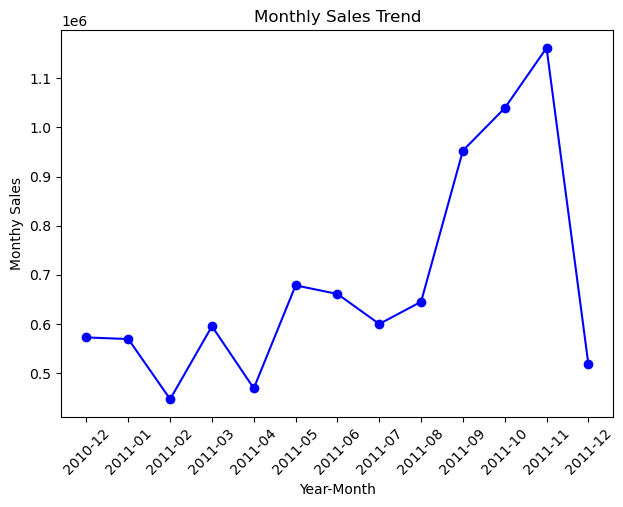

In [154]:
MonthDf = MonthlySales.DataFrame()
MonthDf['YearMonth'] = MonthDf['Year'].astype(str)+'-'+MonthDf['Month'].astype(str).str.zfill(2)


plt.plot(MonthDf['YearMonth'], MonthDf['MonthlySales'], marker = 'o', color = 'b')
plt.xlabel('Year-Month')
plt.ylabel('Monthy Sales')
plt.title('Monthly Sales Trend')
plt.tight_layout()
plt.xticks(rotation = 45)
plt.show()

### Product Analysis


In [183]:
Product = %sql SELECT StockCode, Description, SUM(Quantity) AS TotalSold, ROUND(SUM(TotalAmount),2) AS TotalRevenue , ROUND(AVG(TotalAmount),2) AS AvgPrice, COUNT(DISTINCT CustomerID) AS UniqueCustomers, COUNT(*) AS TransactionFrequency FROM Transactions GROUP BY StockCode, Description ORDER BY TotalRevenue DESC LIMIT 10;
Product

 * sqlite:///Retail.db
Done.


StockCode,Description,TotalSold,TotalRevenue,AvgPrice,UniqueCustomers,TransactionFrequency
23843,"PAPER CRAFT , LITTLE BIRDIE",80995,168469.6,168469.6,1,1
22423,REGENCY CAKESTAND 3 TIER,12402,142592.95,82.76,881,1723
85123A,WHITE HANGING HEART T-LIGHT HOLDER,36725,100448.15,49.53,856,2028
85099B,JUMBO BAG RED RETROSPOT,46181,85220.78,52.67,635,1618
23166,MEDIUM CERAMIC TOP STORAGE JAR,77916,81416.73,411.2,138,198
POST,POSTAGE,3120,77803.96,70.8,331,1099
47566,PARTY BUNTING,15291,68844.33,49.32,708,1396
84879,ASSORTED COLOUR BIRD ORNAMENT,35362,56580.34,40.18,678,1408
M,Manual,7173,53779.93,189.37,197,284
23084,RABBIT NIGHT LIGHT,27202,51346.2,60.98,450,842


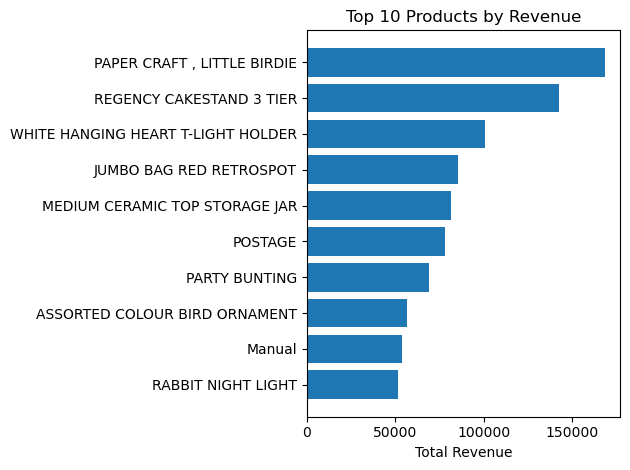

In [193]:
ProductDf = Product.DataFrame()

plt.barh(range(len(ProductDf)), ProductDf['TotalRevenue'])
plt.yticks(range(len(ProductDf)), 
           [desc[:40] + '...' if len(desc) > 40 else desc for desc in ProductDf['Description']])
plt.xlabel('Total Revenue')
plt.title('Top 10 Products by Revenue')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()